<h1>CNN model on GAMEEMO raw dataset, 7 secs grouping</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [8]:
def build_model(sample_size, num_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, sample_size, num_of_features))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [10]:
def train_and_test_model(sample_size, num_of_features,
                         train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(sample_size, num_of_features,
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


In [5]:
# dataset = pd.read_csv('csv/out_gameemo_time_domain_simple.csv',  sep=',')

# print('Shape of data: ', dataset.shape)

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

path="dataset_gameemo/original_data_with_timestamps"
dirs = os.listdir(path)

X_7_sec = []
y = []

num_of_features = 14
num_of_records_per_experiment=37632
num_of_samples = 42
sample_size=int(num_of_records_per_experiment/num_of_samples)

for file in dirs:
    df = pd.read_csv('dataset_gameemo/original_data_with_timestamps/' + file)
    df.drop(columns='timestamps', inplace=True)
    list_of_arrays = np.array_split(df[:num_of_records_per_experiment],num_of_samples)
    for array in list_of_arrays:
        X_7_sec.append(array)
        category = str(file)[4]
        y.append(label_map[int(category)])
X_7_sec = np.array(X_7_sec)
# y = np.array([int(cat)-1 for cat in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_7_sec, y, train_size=0.6, random_state=0)
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=0)


y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train.shape:", y_train.shape)
print("y_validate.shape:", y_validate.shape)
print("y_test.shape:", y_test.shape)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

batch_size = 30
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


y_train.shape: (2822, 4)
y_validate.shape: (941, 4)
y_test.shape: (941, 4)
y_train:
   HA_NV  HA_PV  LA_NV  LA_PV
0      0      0      0      1
1      1      0      0      0
2      0      1      0      0
3      1      0      0      0
4      0      0      1      0


<h3>Manual runs to get a feel of the hyperparameters</h3>

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 50)           2150      
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 22400)             0         
_______________

95/95 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4540.4858 - val_accuracy: 0.7120 - val_precision: 0.7120 - val_recall: 0.7120
Epoch 30/40
95/95 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4540.4858 - val_accuracy: 0.7120 - val_precision: 0.7120 - val_recall: 0.7120
Epoch 31/40
95/95 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4540.4858 - val_accuracy: 0.7120 - val_precision: 0.7120 - val_recall: 0.7120
Epoch 32/40
95/95 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4540.4858 - val_accuracy: 0.7120 - val_precision: 0.7120 - val_recall: 0.7120
Epoch 00032: early stopping


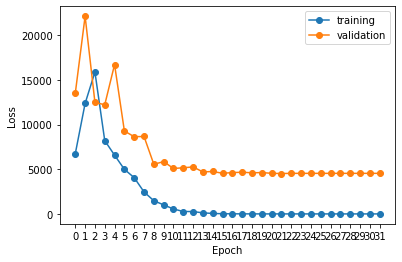

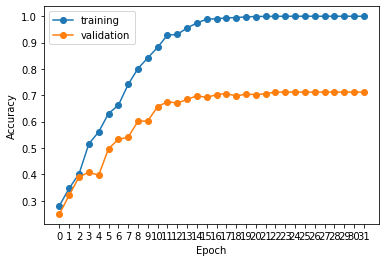

32/32 [==============================] - 0s 5ms/step - loss: 4246.6079 - accuracy: 0.6897 - precision: 0.6897 - recall: 0.6897

Test Acc. 68.97%
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       236
           1       0.72      0.75      0.73       240
           2       0.75      0.69      0.72       239
           3       0.67      0.65      0.66       226

   micro avg       0.69      0.69      0.69       941
   macro avg       0.69      0.69      0.69       941
weighted avg       0.69      0.69      0.69       941
 samples avg       0.69      0.69      0.69       941

Confusion matrix
[[158  31  21  26]
 [ 39 179   9  13]
 [ 27  12 166  34]
 [ 28  26  26 146]]


In [12]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

In [ ]:
Try the best CNN on raw dataset with large sample size config. 
Results: 72.58% test accuracy, but it has extremely large loss 128534!

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 1024)         0         
_________________________________________________________________
flatten (Flatten)            (None, 458752)            0         
_____________

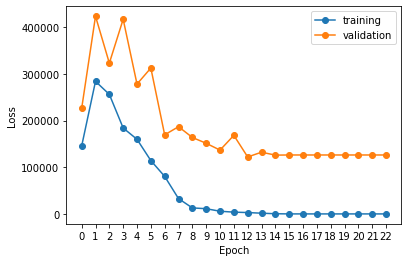

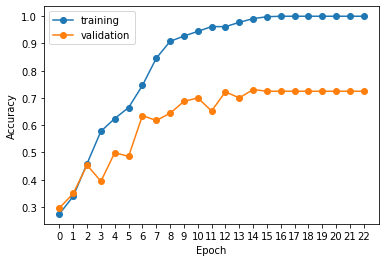

32/32 [==============================] - 0s 7ms/step - loss: 128534.5234 - accuracy: 0.7258 - precision: 0.7258 - recall: 0.7258

Test Acc. 72.58%
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       236
           1       0.76      0.78      0.77       240
           2       0.75      0.70      0.73       239
           3       0.69      0.70      0.70       226

   micro avg       0.73      0.73      0.73       941
   macro avg       0.73      0.73      0.73       941
weighted avg       0.73      0.73      0.73       941
 samples avg       0.73      0.73      0.73       941

Confusion matrix
[[169  22  17  28]
 [ 31 187  10  12]
 [ 25  16 168  30]
 [ 16  22  29 159]]


In [13]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try add 1 dense layer. Results: Accuracy drops to 25%, but loss also drops to a reasonable level.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 1024)         0         
_________________________________________________________________
flatten (Flatten)            (None, 458752)           

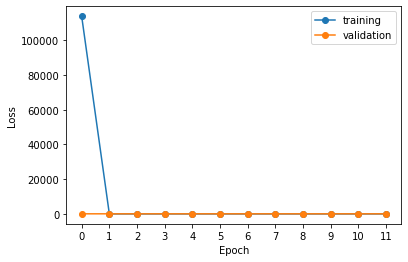

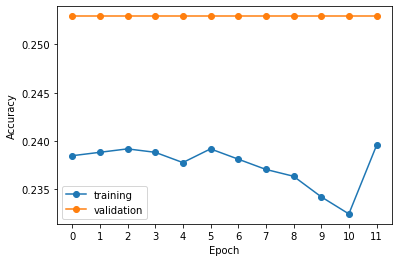

32/32 [==============================] - 1s 11ms/step - loss: 68.9747 - accuracy: 0.2540 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 25.40%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.00      0.00      0.00       240
           2       0.25      1.00      0.41       239
           3       0.00      0.00      0.00       226

   micro avg       0.25      0.25      0.25       941
   macro avg       0.06      0.25      0.10       941
weighted avg       0.06      0.25      0.10       941
 samples avg       0.25      0.25      0.25       941

Confusion matrix
[[  0   0 235   1]
 [  0   0 240   0]
 [  0   0 239   0]
 [  0   0 226   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Back to the model with 72.58% accruacy but massove loss. Try lower the learning rate.
Result: improve loss, accuracy increases to 75.56%

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 1024)         0         
_________________________________________________________________
flatten (Flatten)            (None, 458752)            0         
___________

Epoch 30/40
95/95 [==============================] - 1s 15ms/step - loss: 6.8105e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.1852 - val_accuracy: 0.7736 - val_precision: 0.7745 - val_recall: 0.7736
Epoch 31/40
95/95 [==============================] - 1s 15ms/step - loss: 6.7227e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.1839 - val_accuracy: 0.7736 - val_precision: 0.7745 - val_recall: 0.7736
Epoch 32/40
95/95 [==============================] - 1s 15ms/step - loss: 6.6420e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.1827 - val_accuracy: 0.7736 - val_precision: 0.7745 - val_recall: 0.7736
Epoch 33/40
95/95 [==============================] - 1s 15ms/step - loss: 6.5682e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.1815 - val_accuracy: 0.7726 - val_precision: 0.7734 - val_recall: 0.7726
Epoch 34/40
95/95 [==============================] - 1s 15ms/step - loss: 6.5009e-06 - a

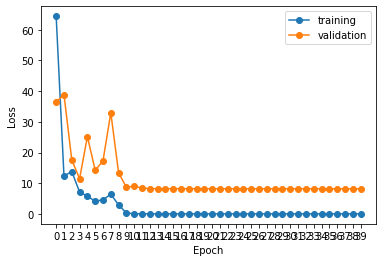

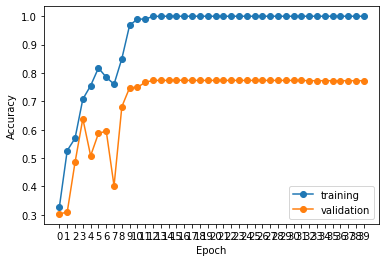

32/32 [==============================] - 0s 7ms/step - loss: 7.5414 - accuracy: 0.7556 - precision: 0.7561 - recall: 0.7545

Test Acc. 75.56%
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       236
           1       0.74      0.80      0.77       240
           2       0.80      0.76      0.78       239
           3       0.80      0.72      0.76       226

   micro avg       0.76      0.76      0.76       941
   macro avg       0.76      0.75      0.76       941
weighted avg       0.76      0.76      0.76       941
 samples avg       0.76      0.76      0.76       941

Confusion matrix
[[177  29  15  15]
 [ 36 191   6   7]
 [ 24  15 181  19]
 [ 16  24  24 162]]


In [15]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try add 1 dense layer again. Results: accuracy drops to 25%.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 1024)         0         
_________________________________________________________________
flatten (Flatten)            (None, 458752)         

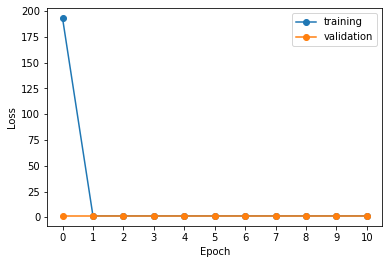

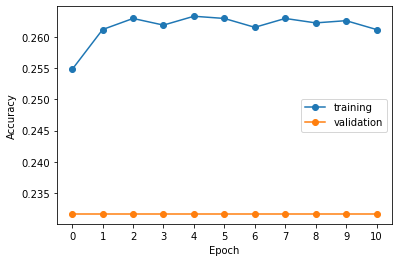

32/32 [==============================] - 0s 10ms/step - loss: 1.3847 - accuracy: 0.2508 - precision: 1.0000 - recall: 0.0011

Test Acc. 25.08%
              precision    recall  f1-score   support

           0       0.25      1.00      0.40       236
           1       1.00      0.00      0.01       240
           2       0.00      0.00      0.00       239
           3       0.00      0.00      0.00       226

   micro avg       0.25      0.25      0.25       941
   macro avg       0.31      0.25      0.10       941
weighted avg       0.32      0.25      0.10       941
 samples avg       0.25      0.25      0.25       941

Confusion matrix
[[235   0   0   1]
 [239   1   0   0]
 [239   0   0   0]
 [226   0   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

Try 2 conv layers. Results: 25% accuracy.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 2
conv_layer_filters[0]; unit:512
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:512
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 512)          22016     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 512)          0         
_________________________________________________________________

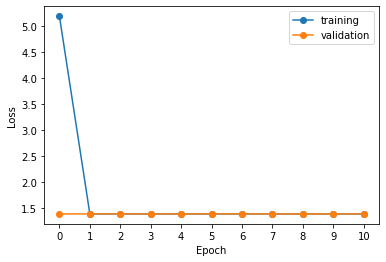

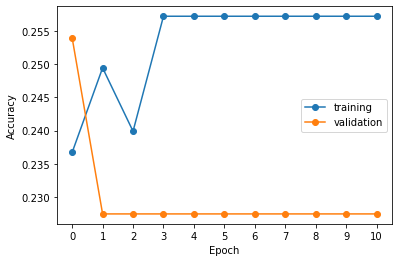

32/32 [==============================] - 0s 8ms/step - loss: 1.3863 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 25.08%
              precision    recall  f1-score   support

           0       0.25      1.00      0.40       236
           1       0.00      0.00      0.00       240
           2       0.00      0.00      0.00       239
           3       0.00      0.00      0.00       226

   micro avg       0.25      0.25      0.25       941
   macro avg       0.06      0.25      0.10       941
weighted avg       0.06      0.25      0.10       941
 samples avg       0.25      0.25      0.25       941

Confusion matrix
[[236   0   0   0]
 [240   0   0   0]
 [239   0   0   0]
 [226   0   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[512,512],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

<h3>Conclusion</h3>

Manual tuning on CNN: 75.56% accuracy </br>
num_of_dense_layers: 0 </br>
num_of_conv_layers: 1 </br>
conv_layer_filters[0]; unit:1024 </br>
conv_kernel[0]; unit:3 </br>
conv_strides[0]; unit:1 </br>
learningRate: 0.001 </br>
isBatchNormalized: False </br>
dropOutRate: 0.5 </br>
startWithBatchNormalized: False </br>
optimizer: Adam </br>
activation: relu </br>
